In [ ]:
Aske Mop Rasmussen

## Data Manipulation

In [171]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import math

#Load csv
def load_data():
    
    electricity_demand_data = pd.read_csv('electricity_demand_data.csv')

    #Feature Engineering

    #Convert DateTime column to pandas DateTime
    electricity_demand_data['DateTime'] = pd.to_datetime(electricity_demand_data['DateTime'])

    #Extract Date from DateTime Column
    electricity_demand_data['Date'] = (electricity_demand_data['DateTime'] - electricity_demand_data['DateTime'].min()).dt.days

    #Extract time as hour + minute fraction
    electricity_demand_data['Time'] = electricity_demand_data['DateTime'].dt.hour + electricity_demand_data['DateTime'].dt.minute / 60
    
     # Extract 'DayOfWeek' as the weekday (0 for Monday, 1 for Tuesday ---> 6 for Sunday etc.)
    electricity_demand_data['DayOfWeek'] = electricity_demand_data['DateTime'].dt.weekday

    # Selecting features X and target Y
    X = electricity_demand_data[['Date', 'Time', 'DayOfWeek']]
    Y = electricity_demand_data['demand']

    return X, Y

In [172]:
#Split data into training and test data
def split_data(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=2710)
    
    #Return split set
    return X_train, X_test, Y_train, Y_test

In [173]:
def plot_data(X,Y):

    # Create subplots for each feature against the target
    num_features = len(X.columns)
    
    fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 5))
    
    for i, col in enumerate(X.columns):
        axes[i].scatter(X[col], Y, color='blue')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Demand')
        axes[i].set_title(f'{col} vs Demand')
    
    plt.tight_layout()
    plt.show()


Upon visualisation of the data as seen in the plot at the bottom, it is clear that we are dealing with non-linear data that lies within a range with a couple of outliers. Therefore, it is crucial to choose a model that performs well with non-linear data.


### Model Development


 Experiments were conducted with three models found appropriate, DecisionTree, KNNRegressor & RandomForestRegressor. All three were found to perform fairly well on test data, but after evaluating error rate and calculating metrics such as R2, MAE & MSE it was decided to proceed with KNNRegressor. Overall KNNRegressor demonstrated higher accuracy and predictability based on the evaluation metrics. Computationally, DecisionTree performed slightly better than KNNRegressor whereas RandomForestRegressor was very slow.

KNN when used with continuous data such as 'demand', it is crucial to obtain the number of neighbours where the model performs best. The number of neighbours have an impact on bias and variance. A lower number of neighbours leads to a more flexible model and lower bias but with a higher variance. Finding the optimal K also helps the model generalise better on unseen data.

In [174]:
#Find optimal number of neighbours for best performance 
def find_optimal_neighbours(X_train, Y_train, X_test, Y_test):
    min_mse = math.inf
    optimal_n = 0
    
    for n in range(1, 100):
        #Initialise Knn regressor
        Knn_model = KNeighborsRegressor(n_neighbors=n)
        #Fit model to training set
        Knn_model.fit(X_train, Y_train)
        #Make predicition on test set
        predictions = Knn_model.predict(X_test)
        #Calculate MSE
        mse = mean_squared_error(Y_test, predictions)
        
        #If MSE improves we update 'optimal_n' with number of neighbours used in model
        if mse < min_mse:
            min_mse = mse
            optimal_n = n

    print(f"Optimal number of neighbours: {optimal_n}")
    return optimal_n

### Model Evaluation

In [175]:
#Train model, evaluate on test data, and print evaluation metrics
def train_and_evaluate(X_train, Y_train, X_test, Y_test, neighbors):
    #Using optimal number of neighbours, initialise KNN regressor
    Knn_model = KNeighborsRegressor(n_neighbors=neighbors)
    #Fit training set to model
    Knn_model.fit(X_train, Y_train)
    #Predict on test set
    predictions = Knn_model.predict(X_test)
    
    #Calculate metrics to evaluate performance 
    mse = mean_squared_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R2): {r2}")
    print(f"Mean Absolute Error (MAE): {mae}")
    
    return Knn_model

Means Squared Error: The average squared difference between predicted values and actual values. A low score indicates that the model is very precise in predicting actual values.

R-squared (R2): R2 represents the proportion of variance in the dependent variable (features) that is predictable from the independent variables (features). A high R2 score (close to 1) indicates that the model fits well on the data. 

Mean Absolute Error (MAE): Provides an interpretation of the average magnitude of errors made by the model. A low score indicates the predicted values are close to the actual values.

A solution to increase the performance of the model would be to experiment by removing outliers such as the ones seen in plot at the bottom of the page.

In [176]:
#Predict future demand
def predict_future_demand(model, latest_timestamp, minutes_ahead):
    future_timestamp = latest_timestamp + minutes_ahead / (24 * 60)
    
    #Prepare input for prediction
    prediction_input = np.array([[latest_timestamp, future_timestamp]])
    
    #Make prediction
    predicted_demand = model.predict(prediction_input.reshape(-1,3))#Causes a warning
    
    return predicted_demand[0]

In [177]:
#Calculate prediction relative error from predicted to actual
def prediction_error_rate(model, X_test, Y_test):
    #Make predictions on test set
    predictions = model.predict(X_test)
    
    #Calculate absolute errors between predicted and actual values
    absolute_errors = np.abs(predictions - Y_test)
    
    #Calculate the average error %
    mean_absolute_error = np.mean(absolute_errors)
    mean_demand = np.mean(Y_test)
    error_rate = (mean_absolute_error / mean_demand) * 100
    
    print(f'Error rate on test data: {error_rate}%')

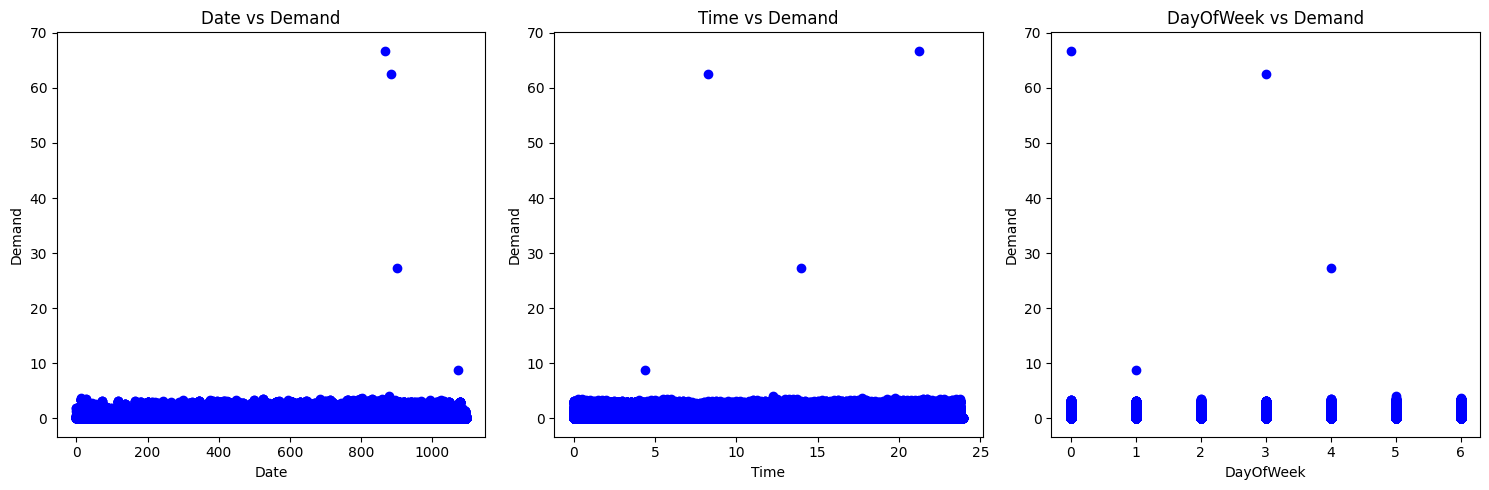

Optimal number of neighbours: 2
Mean Squared Error (MSE): 0.04281448540368958
R-squared (R2): 0.8215853681105554
Mean Absolute Error (MAE): 0.07771179763782812
Error rate on test data: 25.8262010002177%
Predicted demand in the next 15 minutes is 0.0322931258997414


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [178]:
def main():
    #Load Data
    X, Y = load_data()
    #Plot Data
    plot_data(X,Y)
    
    #Split training and test data
    X_train, X_test, Y_train, Y_test = split_data(X, Y)
    
    #Find optimal number of neighbours for model
    optimal_neighbours = find_optimal_neighbours(X_train, Y_train, X_test, Y_test)

    #Obtain latest timestamp from data
    latest_timestamp = X.iloc[-1]  
    
    #Train and evaluate model
    model = train_and_evaluate(X_train, Y_train, X_test, Y_test, optimal_neighbours)
    #Calculate prediction error on test set
    prediction_error_rate(model, X_test, Y_test)
    
    #Make prediction for next 15min
    predict_15min = predict_future_demand(model, latest_timestamp, 15)
    print(f'Predicted demand in the next 15 minutes is {predict_15min}')

if __name__ == "__main__":
    main()

The observed error rate in the model was not a low as anticipated. Initially, the assumption was an underfitting model, yet evaluation metrics such as MSE, R2 & MAE showed satisfactory results. As results were not quite as expected, something else was thought to be influencing the poor performing model.
An attempt to improve the performance was to complexify the model by introducing extra features. Time was split into two features, 'Hour' & 'Minutes'. Upon evaluation of the performance metrics, the model had drastically worsened so it was decided to stay with original number of features. To prevent features on a much larger scale from dominating the 'selection' scaling is almost always a necessity. In the contrary, it was found that attempting to scale the features resulted in a deteriorated model.
Overall, the model's performance isn't optimal but it still provides a prediction of the demand in the next 15 min. Refining the datasheet further could potentially improve the models performance.


## Additional Question

Scaling this solution to 10 additional load profiles would take a lot of planning and consideration.

Conducting an exploratory data analysis of the different load profiles and understanding the data would be a good place to start. 
Confirming whether the features across the 10 load profiles are universal or if some load profiles have unique features. If new features are introduced, it is important they are included to capture each load profile's uniqueness. Likewise, If some load profiles contain data discrepancies or missing data, it is important they are dealt equally across all profiles to ensure integrity.

Following data preparation, my next step would be to investigate the feasibility of using a single model for all load profiles or if there is a need for multiple models. When opting for a model/models, it is important to consider the computational efficiency when working with large data sets, one could even consider cloud-based solutions such as AWS or Azure for data storage and processing.
Using techniques such as cross-validation across various number of folds is also a great way to monitor how a model performs on various sets of training and test data.
Finally, an implementation of a system that regularly monitors performance to be able to tell when/where performance is being slowed down.